In [ ]:
# Install dlroms if needed

try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [ ]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
from dolfin import *
import time

In [ ]:
# Read files from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "./gdrive/MyDrive/DL-ROMs/multi-fidelity"

In [ ]:
%cd "./gdrive/MyDrive/Colab Notebooks/DL-ROMs/multi-fidelity"

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/multi-fidelity


In [ ]:
# Flags

generateData = False
useGPU = True

if useGPU:
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Random seeds

rnd.seed(0)
torch.manual_seed(0)

In [ ]:
# KEY STEPS
# 1. use the FOM to generate a big dataset with a coarse mesh and a small dataset with the refined one
# 2. train a standard DL-ROM on the big dataset
# 3. freeze the obtained model and connect a mesh-informed layer that maps the solution to the refined mesh
# 4. re-train the multi-fidelity model on the small dataset

In [ ]:
# Domain and mesh definition

mesh_H = fe.unitsquaremesh(100, 100)																						# Fine-grained mesh

V_H = fe.space(mesh_H, 'CG', 1) 																								# Continuous piecewise linear finite elements
Nh_H = V_H.dim() 																																# Space dimension (number of dofs)

mesh_C = fe.unitsquaremesh(50, 50)																							# Coarse mesh

V_C = fe.space(mesh_C, 'CG', 1)
Nh_C = V_C.dim()

In [ ]:
# Snapshot generation

def generateSnapshots(N, V):
	"""
	Generate N pairs (mu, u) of parameters and solutions in the FE space V.
	"""

	# Generate mu

	mu = np.zeros((N, 4))

	for i in range(N):
		mu[i] = rnd.uniform(0., 1., size=(1, 4))

	mu1, mu2, mu3, mu4 = mu[:, 0], mu[:, 1], mu[:, 2], mu[:, 3]

	# Generate u

	Nh = V.dim()
	u = np.zeros((N, Nh))

	u_D = Expression('0.01', degree=0)

	def boundary(x, on_boundary):
		return on_boundary

	bc = DirichletBC(V, u_D, boundary) 																						# Dirichlet boundary conditions

	f = Expression('100 * (x[0] * x[1] - x[1] * x[1])', degree=2)									# Source term

	for i in range(N):

		if i % 100 == 0:
			print('Snapshot {}/{}'.format(i, N))

		sigma = Expression('6 + 5 * tanh(20 * (x[1] + 10 * mu1 * x[0] * (x[0] - 1) * (x[0] - mu2) * (x[0] - mu3) - 0.5))',
											 degree=2, mu1=mu1[i], mu2=mu2[i], mu3=mu3[i])						# Diffusion coefficient

		beta = Expression(('10 * cos(2 * pi * mu4)', '10 * sin(2 * pi * mu4)'),
											 degree=2, mu4=mu4[i], pi=np.pi)		                      # Advection coefficient

		uu = TrialFunction(V)
		v = TestFunction(V)

		F = sigma * dot(grad(uu), grad(v)) * dx + \
				dot(beta, grad(uu)) * v * dx - f * v * dx							                  # Variational formulation
		a, L = lhs(F), rhs(F)

		uu = Function(V)																														# Solution function

		solve(a == L, uu, bc)																												# Solution of the variational problem

		u[i] = uu.vector()

	return mu, u

In [ ]:
# Sampling of the high-fidelity and low-fidelity training sets

training_size_H = 300
training_size_C = 4800

if generateData:

	start = time.time()
	mu_train_H, u_train_H = generateSnapshots(training_size_H, V_H)
	#mu_train_C, u_train_C = generateSnapshots(training_size_C, V_C)
	end = time.time()

	print('Snapshots generation time: {:.2f}s'.format(end - start))

	np.save('mu_train_H_'+str(training_size_H)+'.npy', mu_train_H)
	#np.save('mu_train_C_'+str(training_size_C)+'.npy', mu_train_C)
	np.save('u_train_H_'+str(training_size_H)+'.npy', u_train_H)
	#np.save('u_train_C_'+str(training_size_C)+'.npy', u_train_C)

In [ ]:
# Snapshots generation time (75, 600): 1m 11s
# Snapshots generation time (75, 1200): 2m 42s
# Snapshots generation time (150, 2400): 5m 24s
# Snapshots generation time (150, 4800): 11m 2s
# Snapshots generation time (300, 4800): ...

In [ ]:
# Load snapshots

if not generateData:

	mu_train_H = np.load('mu_train_H_'+str(training_size_H)+'.npy')
	mu_train_C = np.load('mu_train_C_'+str(training_size_C)+'.npy')
	u_train_H = np.load('u_train_H_'+str(training_size_H)+'.npy')
	u_train_C = np.load('u_train_C_'+str(training_size_C)+'.npy')

In [ ]:
# Load test data (the same used with the high-fidelity model)

mu_test = np.load('../high-fidelity/mu_test.npy')
u_test = np.load('../high-fidelity/u_test.npy')

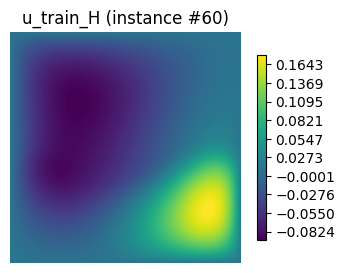

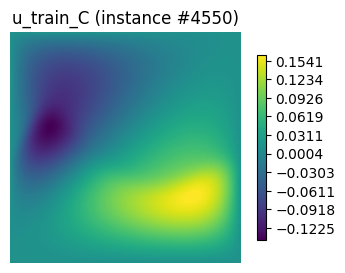

In [ ]:
# Print snapshots

index_H = 60
plt.figure(figsize=(4, 3))
fe.plot(u_train_H[index_H, :], V_H, colorbar=True)
plt.title('u_train_H (instance #' + str(index_H) + ')')
plt.show()

index_C = 4550
plt.figure(figsize=(4, 3))
fe.plot(u_train_C[index_C, :], V_C, colorbar=True)
plt.title('u_train_C (instance #' + str(index_C) + ')')
plt.show()

In [ ]:
# INSTEAD OF GENERATING THE HIGH-FIDELITY TRAINING DATA INDEPENDENTLY, INTERPOLATE THE LOW-FIDELITY DATA ON THE REFINED MESH

In [ ]:
# Traning architecture

m = 16																																					# Decoder
k = 4																																						# Dense NN

# THE LOW-FIDELITY AUTOENCODER HAS 1/3 OF THE DOFS OF THE HIGH-FIDELITY ONE
# HIGH-FIDELITY: 10408 + 308993
# LOW-FIDELITY: 10408 + 116993 (?)

torch.set_default_dtype(torch.float32)

psi_prime = DFNN(Dense(Nh_C, 4, activation=None))

psi = DFNN(Dense(4, 100 * m) + \
			Reshape(4 * m, 5, 5) + \
			Deconv2D(7, (4 * m, 2 * m), 1) + \
			Deconv2D(4, (2 * m, m), 2) + \
			Deconv2D(5, (m, 1), 2, activation=None) + \
			Reshape(-1))
# THE OUTPUT SHOULD BE 51 x 51

phi = DFNN(Dense(4, 50 * k) + \
	  	Dense(50 * k, 50 * k) + \
	  	Dense(50 * k, 4, activation=None))

chi = DFNN(Local(V_C, V_H, support=0.1, activation=None)) # change the support?

print("Trainable parameters:")
print(" Encoder:", psi_prime.dof())
print(" Decoder:", psi.dof())
print(" Dense NN:", phi.dof())
print(" Mesh-informed layer:", chi.dof())

Trainable parameters:
 Encoder: 10408
 Decoder: 116993
 Dense NN: 42004
 Mesh-informed layer: 745414


In [ ]:
# Convert NumPy arrays to tensors on the selected device

u_train_H = torch.tensor(u_train_H, dtype=torch.float32).to(device)
mu_train_H = torch.tensor(mu_train_H, dtype=torch.float32).to(device)
u_train_C = torch.tensor(u_train_C, dtype=torch.float32).to(device)
mu_train_C = torch.tensor(mu_train_C, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)
mu_test = torch.tensor(mu_test, dtype=torch.float32).to(device)

In [ ]:
# Train the autoencoder (nonlinear dimensionality reduction)

autoencoder = DFNN(psi_prime, psi)																							# Encoder + decoder
autoencoder.He()																																# He initialization

autoencoder.to(device)

autoencoder.train(u_train_C, u_train_C, ntrain=training_size_C, epochs=200, loss=mre(euclidean), verbose=True)

		Train		Test
Epoch 200:	3.94e-02	nan.

>> ETA: 2.28s.

Training complete. Elapsed time: 7 minutes 36.54 seconds.


In [ ]:
# Autoencoder training time (T4 GPU, 75, 600): 1m 44s
# Autoencoder training time (T4 GPU, 75, 1200): 2m 19s
# Autoencoder training time (T4 GPU, 150, 2400): 3m 41s
# Autoencoder training time (T4 GPU, 150, 4800): 7m 37s
# Autoencoder training time (T4 GPU, 150, 4800): 7m 37s

In [ ]:
psi_prime.state_dict()
# autoencoder[0].state_dict()

OrderedDict([('0.lin.weight',
              tensor([[ 0.5972, -1.6279,  0.3376,  ...,  0.7439, -0.3051, -0.0901],
                      [ 0.3469, -0.3072, -0.4653,  ...,  0.5222,  0.3616, -0.1307],
                      [-0.2900,  0.7277,  0.4581,  ..., -0.4975, -0.7142, -0.2916],
                      [-1.3523,  1.1096,  0.5007,  ..., -0.4479, -0.6201,  0.1922]],
                     device='cuda:0')),
             ('0.lin.bias',
              tensor([ 0.1664, -0.6409, -0.5773,  0.8703], device='cuda:0'))])

In [ ]:
psi.state_dict()
# autoencoder[1].state_dict()

OrderedDict([('0.0.lin.weight',
              tensor([[-0.0671, -0.0629,  0.1003, -0.0440],
                      [ 0.1058,  0.0289,  0.0249, -0.0461],
                      [ 0.1078,  0.0290, -0.1041,  0.0942],
                      ...,
                      [ 0.0147, -0.1545, -0.0098, -0.0127],
                      [-0.0779, -0.1687,  0.0261, -0.0462],
                      [-0.0282,  0.1267,  0.0845, -0.0291]], device='cuda:0')),
             ('0.0.lin.bias',
              tensor([ 0.4375,  0.3395, -0.1671,  ..., -0.3118,  0.2431,  0.5116],
                     device='cuda:0')),
             ('0.2.deconv.weight',
              tensor([[[[ 1.3942e-02, -3.0017e-02, -5.6570e-02,  ...,  4.1709e-02,
                         -6.0814e-02,  1.3871e-01],
                        [-1.1701e-02, -1.2375e-01, -3.1786e-02,  ..., -6.0347e-03,
                          1.3069e-02, -1.8500e-01],
                        [-4.4043e-03, -9.4014e-02,  5.0914e-03,  ...,  2.7456e-03,
                    

In [ ]:
# Use the trained encoder to generate the reduced order version of the low-fidelity dataset

autoencoder.freeze()

psi_prime.eval()

with torch.no_grad():
  u_train_C_ro = psi_prime(u_train_C)

In [ ]:
# Use the low-fidelity reduced dataset to train the dense NN mapping the parameters to the reduced order low-fidelity solution

phi.He()

phi.to(device)

phi.train(mu_train_C, u_train_C_ro, ntrain=training_size_C, epochs=200, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 200:	2.72e-02	nan.

>> ETA: 0.30s.

Training complete. Elapsed time: 1 minutes 0.62 seconds.


In [ ]:
# Dense NN training time (T4 GPU, 75, 600): 1m
# Dense NN training time (T4 GPU, 75, 1200): 1m 12s
# Dense NN training time (T4 GPU, 150, 2400): 1m 4s
# Dense NN training time (T4 GPU, 150, 4800): 56s
# Dense NN training time (T4 GPU, 300, 4800): 1m 1s

In [ ]:
# FREEZE THE DENSE NN + DECODER

phi.freeze()
psi.freeze() # psi is already frozen since autoencoder.freeze()?

In [ ]:
phi.state_dict()

OrderedDict([('0.0.lin.weight',
              tensor([[-1.5925e-01, -4.0143e-02, -2.4367e-01,  1.2070e-02],
                      [ 2.7158e-02,  1.8285e-02, -2.4281e-01,  2.7273e-02],
                      [-4.7167e-01, -1.2524e-01,  1.1579e+00,  5.7241e-02],
                      [ 2.3838e-01, -6.1633e-01,  7.4667e-01, -1.1645e-01],
                      [-1.0662e-02, -5.6545e-02, -1.1907e-01, -1.3063e-01],
                      [ 1.8459e-01,  1.1559e-01,  3.1948e-01, -1.0884e+00],
                      [-5.6032e-02, -3.7217e-02, -8.6113e-03, -7.9980e-02],
                      [ 1.8699e-01,  1.2011e-01,  5.4762e-01,  1.0957e+00],
                      [-7.9242e-02, -1.3769e-01, -1.2975e-01,  2.8814e-02],
                      [-4.0425e-02, -3.6803e-02, -6.7876e-04,  2.3181e-02],
                      [-9.3053e-02, -4.0891e-03,  3.4570e-02, -7.0676e-02],
                      [-6.5025e-02, -1.3699e-01,  8.2741e-02,  9.2254e-02],
                      [-2.4239e-01,  1.1549e-01, -3.1043

In [ ]:
# TRAIN THE MULTI-FIDELITY MODEL

chi.He() # change initialization for chi?
if useGPU:
  chi.cuda()
else:
  chi.cpu()

model = DFNN(phi, psi, chi)

model.to(device)

model.train(mu_train_H, u_train_H, ntrain=training_size_H, epochs=40, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 40:	1.08e-01	nan.

>> ETA: 0.71s.

Training complete. Elapsed time: 28.30 seconds.


In [ ]:
# Multi-fidelity model training time (T4 GPU, 75, 600): 23s
# Multi-fidelity model training time (T4 GPU, 75, 1200): 23s
# Multi-fidelity model training time (T4 GPU, 150, 2400): 27s
# Multi-fidelity model training time (T4 GPU, 150, 4800): 27s
# Multi-fidelity model training time (T4 GPU, 300, 4800): 28s

In [ ]:
# Use the final model to predict the high-fidelity solution

model.eval()

with torch.no_grad():
  u_train_H_pred = model(mu_train_H)

In [ ]:
# Compute the relative error

error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

Relative training error: 3.77%


In [ ]:
# Relative training error (75, 600): 4.37%
# Relative training error (75, 1200): 3.22%
# Relative training error (150, 2400): 3.33%
# Relative training error (150, 4800): 3.32%
# Relative training error (300, 4800): 3.77%

In [ ]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = model(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative test error: 3.98%


In [ ]:
# Relative test error (75, 600): 6.59%
# Relative test error (75, 1200): 5.29%
# Relative test error (150, 2400): 4.28%
# Relative test error (150, 4800): 4.21%
# Relative test error (300, 4800): 3.98%

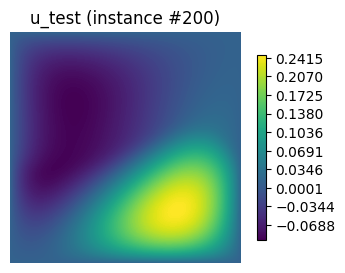

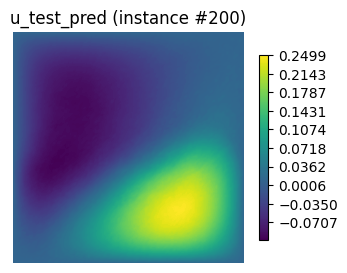

In [ ]:
# Plot some results

index = 200

plt.figure(figsize=(4, 3))
fe.plot(u_test[index, :], V_H, colorbar=True)
plt.title('u_test (instance #' + str(index) + ')')

plt.figure(figsize=(4, 3))
fe.plot(u_test_pred[index, :], V_H, colorbar=True)
plt.title('u_test_pred (instance #' + str(index) + ')')

plt.show()

In [ ]:
# Save encoder, decoder, and dense NN

psi_prime.save('./psi_prime_'+str(training_size_C)+'_'+str(training_size_H))
psi.save('./psi_'+str(training_size_C)+'_'+str(training_size_H))
phi.save('./phi_'+str(training_size_C)+'_'+str(training_size_H))